# main.py

In [1]:
'''
File : Main notebook
Author : Jehan Corcelle, Raphaël Dousson, Arto Dubuisson, Benoît Gallois
Date : 06 déc 2023
Robot control and management of vision, global navigation, local navigation and Kalman filter.
'''

'\nFile : Main notebook\nAuthor : Jehan Corcelle, Raphaël Dousson, Arto Dubuisson, Benoît Gallois\nDate : 06 déc 2023\nRobot control and management of vision, global navigation, local navigation and Kalman filter.\n'

TO DO:

- commentaires tous en anglais
- virer les prints inutiles

### Initialisations

In [2]:
# Import libraries
import time
from tdmclient import ClientAsync
import numpy as np
import math

# Import project files
import vision
import global_navigation as gn
import local_navigation as ln
import extended_Kalman_filter as eKf

In [3]:
# Connect to Thymio
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 328bdb70-11b8-49f9-b631-ac6519113084

In [4]:
# Convertion ratios
PIXEL_TO_CM_RATIO = 0.05406       
CM_TO_PIXEL_RATIO = 18.4971

In [5]:
# Eteint les LED    ->> A SUPPRIMER après check

'''
await node.set_variables({
            'leds.bottom.left': [0, 0, 0],
            'leds.bottom.right': [0, 0, 0],
            'leds.circle': [0, 0, 0, 0, 0, 0, 0, 0],
            'leds.top': [0, 0, 0],
        })
'''

"\nawait node.set_variables({\n            'leds.bottom.left': [0, 0, 0],\n            'leds.bottom.right': [0, 0, 0],\n            'leds.circle': [0, 0, 0, 0, 0, 0, 0, 0],\n            'leds.top': [0, 0, 0],\n        })\n"

In [6]:
# Set the motor speeds
async def stop_robot():
    '''
    @brief   Stop the robot. Set the motor speed of each wheel to zero.
    '''
    await node.set_variables({
            "motor.right.target": [0],
            "motor.left.target": [0],
        })

    
async def move_robot(right_speed, left_speed):
    '''
    @brief   Turn the robot wheels to the given speeds.

    @param   right_speed -> right wheel speed in [thymio speed]
             left_speed  -> left wheel speed in [thymio speed]
    '''
    await node.set_variables({
            "motor.right.target": [right_speed],
            "motor.left.target": [left_speed],
        })

In [7]:
# Get the proximity sensor values
async def get_prox_sensors():
    '''
    @brief   Get the sensor measurements of a the proximity sensors.

    @return  prox_sensors  -> numpy array of fron proximity sensors measurements
             detected      -> boolean = True if any sensors measured a higher value than threshold
    '''
    await node.wait_for_variables({str('prox.horizontal')})
    prox_sensors = np.asarray(list(node['prox.horizontal']))
    prox_sensors = prox_sensors[0:5]

    prox_sensors_bool = (prox_sensors >= np.array([4000, 2000, 1000, 2000, 4000])) #METTRE DANS CONSTANTS.py!!!!
    detected = False
    if(any(prox_sensors_bool)):
        detected = True

    return prox_sensors, detected



# Get the motor speed measurement values
async def get_motor_speed_meas():
    '''
    @brief   Get the motor speed measurements.

    @return  speed_left_meas    -> left wheel speed in [thymio speed]
             speed_right_meas   -> right wheel speed in [thymio speed]
    '''
    
    await node.wait_for_variables({str('motor.right.speed')})
    speed_right_meas = node['motor.right.speed']
    await node.wait_for_variables({str('motor.left.speed')})
    speed_left_meas = node['motor.left.speed']

    return speed_right_meas, speed_left_meas

In [8]:
#METTRE AILLEURS

def is_inside(point, obstacles):
    for obstacle in range(len(obstacles)):
        min_x = min(s[0] for s in obstacles[obstacle])
        max_x = max(s[0] for s in obstacles[obstacle])
        min_y = min(s[1] for s in obstacles[obstacle])
        max_y = max(s[1] for s in obstacles[obstacle])
        for summit in range(len(obstacles[obstacle])):
            if min_x <= point[0] <= max_x and min_y <= point[1] <= max_y:
                return True
    return False

In [9]:
'''
# Test connection thymio/computer

await move_robot(50, 50)
dt = 0
old_time = time.time()
while(dt < 2):
    y,d = await get_prox_sensors()
    print(y)
    print(d)
    await client.sleep(0.1)
    dt = time.time() - old_time
await stop_robot()
'''

'\n# Test connection thymio/computer\n\nawait move_robot(50, 50)\ndt = 0\nold_time = time.time()\nwhile(dt < 2):\n    y,d = await get_prox_sensors()\n    print(y)\n    print(d)\n    await client.sleep(0.1)\n    dt = time.time() - old_time\nawait stop_robot()\n'

### Step 1: Detect the map with vision and global path planning

Coordonnées obstacles noirs : [[(541, 1080), (857, 1080), (857, 597), (541, 597)], [(1048, 1080), (1360, 1080), (1360, 605), (1048, 605)], [(0, 1080), (463, 1080), (463, 503), (0, 503)]]
Centroid de la goal area : [1627.  569.]
Vecteur direction du robot : 92 -8
Centroid du robot : [456 433]


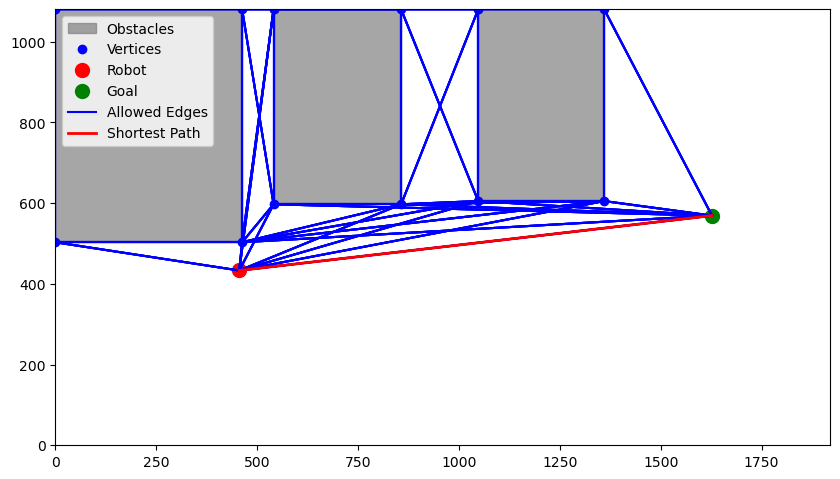

In [10]:
# Get the coordinates of the obstacles and the goal coordinates
obstacles, goal_centroid = vision.vision_obstacles_and_goal()
robot_centroid, robot_direction = vision.vision_robot()

# Get the robot initial position and its direction
while robot_centroid[0] == 0 and robot_centroid[1] == 0:
    robot_centroid, robot_direction = vision.vision_robot()

merge_need = True   #FAIRE EN SORTE DE PLUS AVOIR BESOIN DE METTRE MERGE EN TRUE -> tjrs valide!!!
visualize = True    # PAREIL!!!!

# Compute the shortest path with the global navigation
shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid), merge_need, visualize)

# Convert the cordinates of the goals and the robot position in centimeter
shortest_path = vision.converter(shortest_path, PIXEL_TO_CM_RATIO)
robot_centroid = vision.converter(robot_centroid, PIXEL_TO_CM_RATIO)

1 rotation
Kalman:  24.0 23.0 -0.08673833867598511 0.0 0.0
[-0.08673834] [0.11065722] [0.19739556]
[(87, 30)]
2 rotation
Kalman:  22.659508426207676 23.045370813262082 -0.07016698789501846 0.9570015705429916 -0.6930011374053208
[-0.07016699] [0.10767298] [0.17783997]
[(87, 30)]
3 rotation
Kalman:  22.82414673021872 23.03782852132104 -0.0072283257461770774 1.4173096542163537 -1.2142325038518107
[-0.00722833] [0.10806323] [0.11529155]
[(87, 30)]
4 rotation
Kalman:  22.963960124647656 23.033892400233338 0.0775302808922022 1.5610312768552945 -1.5173548596158049
[0.07753028] [0.10835808] [0.0308278]
[(87, 30)]
5 translation
Kalman:  22.957303541565345 23.03445422038803 0.10175712224601914 1.6500018253320732 -1.5653388291271462
trabslation: [(87, 30)]
Error: [64.4203834]
6 translation
Kalman:  22.963348407707848 23.0565228753814 0.16433180911235956 1.4460528796117376 0.37083849690884385
trabslation: [(87, 30)]
Error: [64.41199129]
7 translation
Kalman:  23.434329350478784 23.142962714942545 

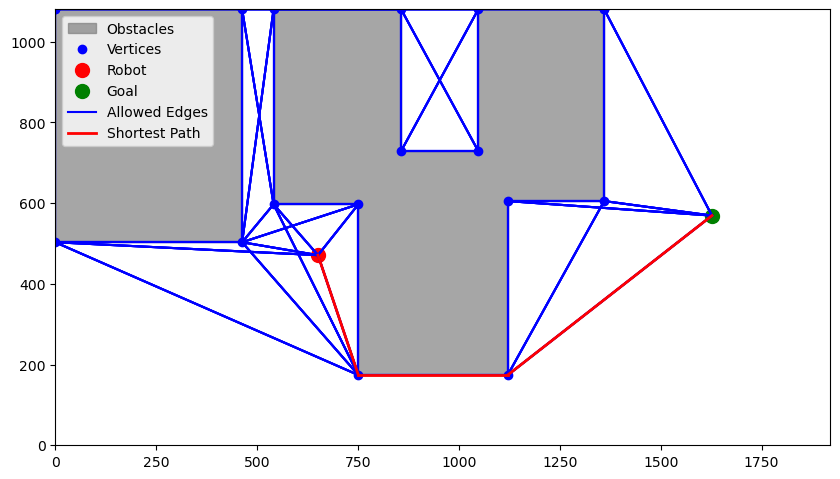

glob nav path : [(651.0, 471.0), (751.0, 174.0), (1121.0, 174.0), (1627.0, 569.0)]
camera measurements:  (35, 25) 0.029694239606909516
centroid camera:  (35, 25)
camera fin: [(40, 9), (60, 9), (87, 30)]
31 rotation
Kalman:  35.00000565940913 25.00006570059554 0.03018995458889509 -1.8201823308628677 -1.3970118325319187
[0.03018995] [-1.26791295] [-1.2981029]
[(40, 9), (60, 9), (87, 30)]
32 rotation
Kalman:  34.43888486898087 24.9830675754171 0.006287763069868531 -1.7064762062582504 -0.23513475373448967
[0.00628776] [-1.23595974] [-1.2422475]
[(40, 9), (60, 9), (87, 30)]
33 rotation
Kalman:  34.1716474082979 24.98057181866839 -0.05244925760223341 -1.6363600843373851 0.860902137837497
[-0.05244926] [-1.22107308] [-1.16862382]
[(40, 9), (60, 9), (87, 30)]
34 rotation
Kalman:  34.071746489490394 24.9864524337204 -0.13297249257920998 -1.6107247045254343 1.3145364648767033
[-0.13297249] [-1.2156867] [-1.0827142]
[(40, 9), (60, 9), (87, 30)]
35 rotation
Kalman:  34.03467516511355 24.9920455811

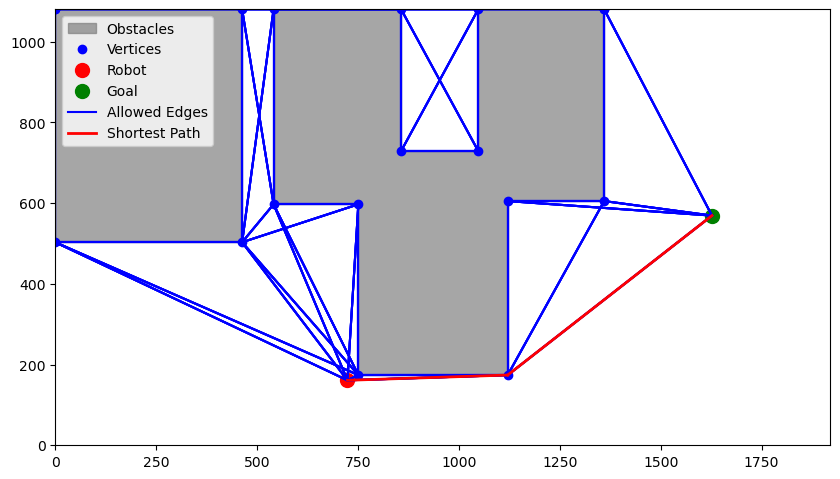

glob nav path : [(724.0, 161.0), (1121.0, 174.0), (1627.0, 569.0)]
camera measurements:  (39, 8) -1.2812926548335084
centroid camera:  (39, 8)
camera fin: [(60, 9), (87, 30)]
70 rotation
Kalman:  38.997417338448976 8.000877449858919 -1.304985019174803 8.855579426025283 -0.39711636076832635
[-1.30498502] [0.04753558] [1.3525206]
[(60, 9), (87, 30)]
71 rotation
Kalman:  39.27588985657416 6.935492661754112 -1.1292469770022922 3.4157341384511923 -0.7642379665871386
[-1.12924698] [0.09929104] [1.22853802]
[(60, 9), (87, 30)]
72 rotation
Kalman:  39.43609757943816 6.629653306384309 -1.023474393683459 2.2657594953583873 -1.2013703374216944
[-1.02347439] [0.11476089] [1.13823528]
[(60, 9), (87, 30)]
73 rotation
Kalman:  39.516664604963815 6.5064089109466385 -0.9248990340615605 1.9181492514033278 -1.4102744147904638
[-0.92489903] [0.12114146] [1.04604049]
[(60, 9), (87, 30)]
74 rotation
Kalman:  39.55705959538804 6.45673192436993 -0.8277999764757671 1.752358005198014 -1.5584065697148948
[-0.827

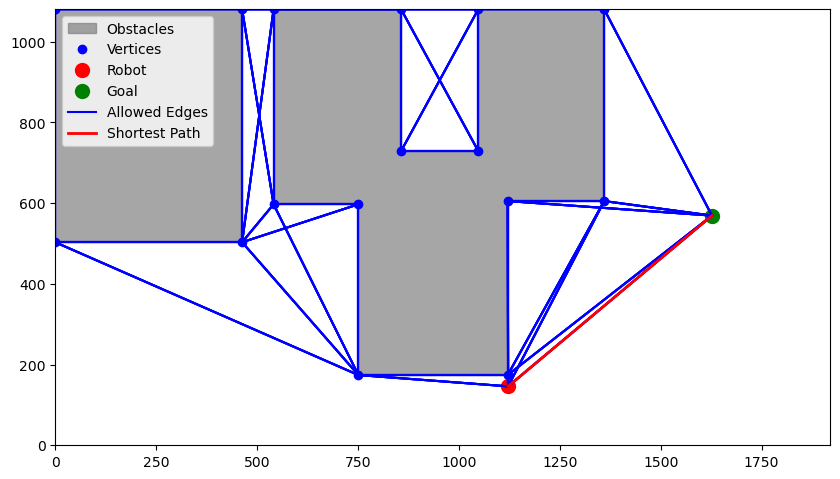

glob nav path : [(1122.0, 146.0), (1627.0, 569.0)]
camera measurements:  (60, 7) -0.11825750913907943
centroid camera:  (60, 7)
camera fin: [(87, 30)]
113 rotation
Kalman:  60.00022426594534 7.000144618897839 -0.1163680174276194 0.7768281161903358 1.474714214825503
[-0.11636802] [0.70556917] [0.82193719]
[(87, 30)]
114 rotation
Kalman:  60.34973876827778 6.959177529154756 -0.11921823783263322 0.8974864509731364 -0.12296044425845043
[-0.11921824] [0.71288796] [0.8321062]
[(87, 30)]
115 rotation
Kalman:  60.4551458132951 6.945695692248164 -0.07027124957129904 1.2928523726244607 -0.9963046627174287
[-0.07027125] [0.71513882] [0.78541007]
[(87, 30)]
116 rotation
Kalman:  60.50140146463065 6.942337484608557 0.006255693476869049 1.513459870113699 -1.332183677445549
[0.00625569] [0.71607449] [0.70981879]
[(87, 30)]
117 rotation
Kalman:  60.528529282482964 6.942749585119076 0.09289283190054837 1.5638504899392878 -1.4606147870962918
[0.09289283] [0.71657289] [0.62368006]
[(87, 30)]
118 rotation

163 translation
Kalman:  84.19573749913228 26.686065678780952 0.7076147657696817 2.0474911725099214 2.01747803276769
trabslation: [(87, 30)]
Error: [4.34120362]
164 translation
Kalman:  84.83288259197272 27.23126886391944 0.7081587143578228 2.107756307836284 2.0962923208909734
trabslation: [(87, 30)]
Error: [3.51600199]
165 translation
Kalman:  85.46619643345794 27.773382363575223 0.7088285492644033 2.054293683025248 2.024420889895011
trabslation: [(87, 30)]
Error: [2.70377134]
166 translation
Kalman:  86.08485641803927 28.303487668226737 0.7102939144612133 2.033872799433607 1.9714745311217303
trabslation: [(87, 30)]
Error: [1.92760003]
167 translation
Kalman:  86.7050642335923 28.837347259006858 0.7114247396854488 2.0515666688415046 2.0277326768139794
trabslation: [(87, 30)]
Error: [1.19947843]
168 translation
Kalman:  87.32888591563766 29.37619455999216 0.7104706358762509 2.0073372293510214 2.074715297690045
trabslation: [(87, 30)]
Error: [0.70519442]
je m'arrete
169 camera
Kalman:  

/Users/benoitgallois/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/benoitgallois/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/benoitgallois/Desktop/EPFL/MA3/Mobile Robotics/Projet - Vision/Code final/vision.py:93: RuntimeWarning: invalid value encountered in cast
  direction = (front_centroid - back_centroid).astype(int)
/Users/benoitgallois/Desktop/EPFL/MA3/Mobile Robotics/Projet - Vision/Code final/vision.py:94: RuntimeWarning: invalid value encountered in cast
  midpoint = ((front_centroid + back_centroid) / 2).astype(int)


Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 59 53
Centroid du robot : [1556  563]


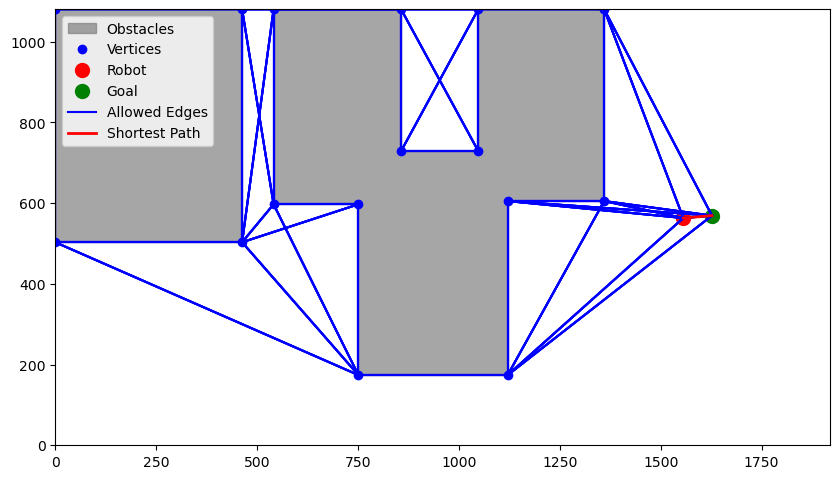

glob nav path : [(1556.0, 563.0), (1627.0, 569.0)]
camera measurements:  (84, 30) 0.7318778949381332
centroid camera:  (84, 30)
camera fin: []
170 rotation
je suis au goal


In [11]:
#ROBOT CONTROL AND LOCALISATION

# state variables
global_state = 'rotation'

#speed_correction = 12.5 #calibration cst for rotation counterclockwise
speed_correction = 14 #calibration cst for rotation counterclockwise
#speed_correction = 0.75 #0.65 #calibration cst for translation

intermediate_goals = shortest_path
intermediate_goals.pop(0)
robot = [(robot_centroid[0],robot_centroid[1])]
robot_orientation = np.arctan2(robot_direction[1], robot_direction[0])

#intermediate_goals = [(0, 10), (-10, 10), (-10, 0), (0,0)]
#intermediate_goals = [(56, 34), (66, 34), (87, 26)]
#robot = [(34.0,28.0)]
#robot_orientation = 1.6
robot_speed = [0.0,0.0]

Kfilter = eKf.Kalman(robot[0][0], robot[0][1], robot_orientation)

#robot_speed = [30, -30] #robot speed for rotation (counterclockwise)
#robot_speed = [-30, 30] #robot speed for rotation (clockwise)
#robot_speed = [50, 50] #robot speed for translation
#await move_robot(robot_speed[0], robot_speed[1])

old_time = 0.0
printkal = True
iter = 0
while(True):
    iter = iter + 1
    print(iter, global_state)

    if intermediate_goals == []:
        await stop_robot()
        print("je suis au goal")
        break
    
    # get robot sensor values
    prox_sensors, detected = await get_prox_sensors()
    # test if local (with proximity)
        
    if(detected):
        await stop_robot()
        global_state = 'local_avoidance'

    
    speed_right_meas, speed_left_meas = await get_motor_speed_meas()
    #print(speed_right_meas, speed_left_meas, "  ", robot_speed[0], robot_speed[1])
    speed_right_meas = speed_right_meas * speed_correction
    speed_left_meas = speed_left_meas * speed_correction
    
    #speed_right_meas = robot_speed[0] * speed_correction
    #speed_left_meas = robot_speed[1] * speed_correction

    Kfilter.measurement_wheels(speed_right_meas / 18.1818, speed_left_meas / 18.1818)

    if iter == 0:                   # first time
        old_time = time.time()
    dt = time.time() - old_time     # get time difference for Kalman
    old_time = time.time()

    Kfilter.dt_update(dt)
    Kfilter.Kalman_filter()
    #print(dt, time.time(), old_time)
    if printkal:
        print("Kalman: ", Kfilter.Mu[0][0], Kfilter.Mu[1][0], Kfilter.Mu[2][0], Kfilter.Mu[3][0], Kfilter.Mu[4][0])
        #printkal = False
    #print("Kalman Sigma: ", Kfilter.Sigma)
    #print("Kalman y: ", Kfilter.y)
    
    robot.append((Kfilter.Mu[0][0], Kfilter.Mu[1][0]))
    
    if global_state == 'rotation':
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = eKf.center_angle(angle)
        print(Kfilter.Mu[2], np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]), angle)
        print(intermediate_goals)
        if(abs(angle) < 0.1):
            await stop_robot()
            global_state = 'translation'
            continue

        if(angle > 0):
            robot_speed = [30, -30]         # counterclockwise
            speed_correction = 1.0 #32 #14
        else:
            robot_speed = [-30, 30]         # clockwise
            speed_correction = 1.0 #12.5

    elif global_state == 'translation':
        
        print("trabslation:", intermediate_goals)
        print("Error:", np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2))
        #if(np.sqrt(Kfilter.Mu[0][0]**2 + Kfilter.Mu[1][0]**2) > 10.0):     #translation condition
        
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= 0.8:
            print("je m'arrete")
            await stop_robot()
            #intermediate_goals.pop(0)
            global_state = 'camera'
            continue
            
        
        
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = eKf.center_angle(angle)
        
        P_control_translation = 0 / (math.pi / 4.0)
        robot_speed = [50 + int(P_control_translation*angle), 50 - int(P_control_translation*angle)]
        speed_correction = 0.75

        
        if abs(angle) > math.pi / 2.0:
            await stop_robot()
            global_state = 'camera'
            continue
        
        
    elif global_state == 'camera':
        robot_centroid = [0,0]
        while robot_centroid[0] == 0 and robot_centroid[1] == 0:
            robot_centroid, robot_direction = vision.vision_robot()
            
        merge_need = True
        visualize = True
        shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid), merge_need, visualize)
        print("glob nav path :", shortest_path)
        
        
        shortest_path = vision.converter(shortest_path, PIXEL_TO_CM_RATIO)
        robot_centroid = vision.converter(robot_centroid, PIXEL_TO_CM_RATIO) #changer pixel
        
        robot_angle = np.arctan2(robot_direction[1], robot_direction[0]) 
    
        Kfilter.measurement_position(robot_centroid[0], robot_centroid[1], robot_angle)
        #print("Kalman: ", Kfilter.Mu[0][0], Kfilter.Mu[1][0], Kfilter.Mu[2][0], Kfilter.Mu[3][0], Kfilter.Mu[4][0])
        print("camera measurements: ", robot_centroid, robot_angle)
        printkal = True
        
        intermediate_goals = shortest_path
        intermediate_goals.pop(0)
        
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= 0.8:
            intermediate_goals.pop(0)

        print("centroid camera: ", robot_centroid)
        print("camera fin:", shortest_path)
        
        global_state = 'rotation'
        continue
        
        
        
    elif global_state == 'local_avoidance':
        print("local")
        robot_direction = (math.cos(Kfilter.Mu[2][0]), math.sin(Kfilter.Mu[2][0]))
        object_robot_coords = ln.object_robot_coordinates(prox_sensors)
        object_ground_coords = ln.robot_to_ground_coords([Kfilter.Mu[0][0], Kfilter.Mu[1][0]], robot_direction, object_robot_coords)
        
        if is_inside(object_ground_coords, obstacles):
            continue

        Object = ln.safety_zone(object_ground_coords)
        Object = vision.converter(Object, CM_TO_PIXEL_RATIO)
        
        print("OBject:", Object)
        print("avant append:", obstacles)
        obstacles.append(Object)
        print("après append:", obstacles)
        prox_sensors_bool = True
        
        while prox_sensors_bool:
            await move_robot(-50, -50)
            await client.sleep(2)
            prox_sensors, detected = await get_prox_sensors()
            prox_sensors_bool = any(prox_sensors >= np.ones(5) * 20) #cst.THRESHOLD_PROX_SENSOR
            await client.sleep(0.4)
        
        global_state = "camera"
        continue

        
        
    await move_robot(robot_speed[0], robot_speed[1])
    await client.sleep(0.3)


    

In [15]:
await stop_robot()